In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
#Set Seed for repeatable Experiments
np.random.seed(123)

import itertools
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

import struct
import gzip
import tarfile

import sys
import math



import PIL
from PIL import Image 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import torch.utils.data as data_utils

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

gpuid = 0
if torch.cuda.is_available():
  print(torch.cuda.get_device_properties(gpuid))
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')
device

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def print_Images(images,labels,labels_dict,random = True):
    seed = 123
    obs= np.unique(labels)
    fig,ax = plt.subplots(nrows = 2, ncols = 5,figsize = (14,4))
    ax = ax.flatten()
    for i in obs:
        imgs = images[labels == i,:]
        n = imgs.shape[0]
        if random:
            index = np.random.choice(np.arange(n),size=1,replace = False)
        else:
            index = 0
        image = imgs[index].squeeze()
        xlabel = "{}".format(labels_dict[i])
        ax[i].imshow(image, interpolation='nearest')   
        ax[i].set_xlabel(xlabel)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_aspect('auto')
    plt.tight_layout()
    plt.subplots_adjust(wspace=1.2, hspace=0.4)
    plt.show()
    plt.close() 

In [ ]:
#specify data to use
#use_data = 'Cifar-100'
use_data = 'Cifar-10'

In [ ]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/Data/{}'.format(use_data)

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict 

def fetchData(file_dir,data_type = 'Cifar-10',reshape_asimg = True):
  if data_type == 'Cifar-10':
    X_train, Y_train, X_test, Y_test, cifar10_dict = fetchCIFAR10(file_dir,reshape_asimg = True)
    return X_train, Y_train, X_test, Y_test, cifar10_dict
  elif data_type == 'Cifar-100':
    X_train, Y_train, X_test, Y_test, cifar100_dict = fetchCIFAR100(file_dir,reshape_asimg = True)
    return X_train, Y_train, X_test, Y_test, cifar100_dict
  else:
    print('Invalid Data Type. Must be cifar-10 or cifar-100.')

  

def fetchCIFAR100(file_dir,reshape_asimg = True):
  skip_extract = False
  file_name = file_dir + '/cifar-100-python.tar.gz'
  #If meta exists no need to extract (Assumption: other files arent deleted)
  if os.path.isfile(data_dir + '/meta'):
    skip_extract = True
  if skip_extract == False:
    print('Extracting Files')
    length = len('cifar-100-python/')
    with tarfile.open(file_name, 'r:gz') as tar:
      subdir_and_files = []
      for tarinfo in tar.getmembers():
        if tarinfo.name.startswith("cifar-100-python/"):
          tarinfo.name = tarinfo.name[length:]
          subdir_and_files.append(tarinfo)
      print(subdir_and_files)
      tar.extractall(members=subdir_and_files,path = file_dir)
  else:
    print('Skipping Extraction')

  #Unpickle training and test data also meta file
  train_dict = unpickle(file_dir + "/train")
  test_dict = unpickle(file_dir + "/test")
  meta = unpickle(file_dir + "/meta")

  X_train = train_dict[b'data']
  Y_train = np.asarray(train_dict[b'fine_labels'])
  #Y_train_coarse = np.asarray(train_dict[b'coarse_labels'])

  X_test = test_dict[b'data']
  Y_test = np.asarray(test_dict[b'fine_labels'])
  #Y_test_coarse = np.asarray(test_dict[b'coarse_labels'])

  if reshape_asimg == True:
    X_train = X_train.reshape([-1,3,32,32]).transpose(0,2,3,1) #Reshape to image dimensions
    X_test = test_dict[b'data'].reshape([-1,3,32,32]).transpose(0,2,3,1)

  cifar100_dict = dict(zip(np.arange(100),[label.decode('utf-8') for label in meta[b'fine_label_names']]))
  #cifaf100_coarse_dict = dict(zip(np.arange(20),[label.decode('utf-8') for label in meta[b'coarse_label_names']]))

  N_train = X_train.shape[0]
  width = X_train.shape[1]
  height = X_train.shape[2]
  channels = X_train.shape[3]
  N_test = X_test.shape[0]
  print('{} Training Images and {} Test Images\n Images have Shape: {}x{}x{}'.format(N_train,N_test,width,height,channels))

  return X_train, Y_train, X_test, Y_test, cifar100_dict

def fetchCIFAR10(file_dir,reshape_asimg = True):
  skip_extract = False
  file_name = file_dir + '/cifar-10-python.tar.gz'
  #If batches.meta exists no need to extract (Assumption: other files arent deleted)
  if os.path.isfile(data_dir + '/batches.meta'):
    skip_extract = True

  if skip_extract == False:
    print('Extracting Files')
    length = len('cifar-10-batches-py/')
    with tarfile.open(file_name, 'r:gz') as tar:
      subdir_and_files = []
      for tarinfo in tar.getmembers():
        if tarinfo.name.startswith("cifar-10-batches-py/"):
          tarinfo.name = tarinfo.name[length:]
          subdir_and_files.append(tarinfo)
      print(subdir_and_files)
      tar.extractall(members=subdir_and_files,path = file_dir)
  else:
    print('Skipping Extraction')
  #Unpickle training and test data also meta file
  train_dict_1 = unpickle(file_dir + "/data_batch_1")
  train_dict_2 = unpickle(file_dir + "/data_batch_2")
  train_dict_3 = unpickle(file_dir + "/data_batch_3")
  train_dict_4 = unpickle(file_dir + "/data_batch_4")
  train_dict_5 = unpickle(file_dir + "/data_batch_5")
  test_dict = unpickle(file_dir + "/test_batch")
  meta = unpickle(file_dir + "/batches.meta")


  #Convert Dictionaries to images (Requires reshaping if we use with convolutional network)
  X_train = np.concatenate([train_dict_1[b'data'],train_dict_2[b'data'],train_dict_3[b'data'],train_dict_4[b'data'],train_dict_5[b'data']])
  Y_train = np.concatenate([train_dict_1[b'labels'],train_dict_2[b'labels'],train_dict_3[b'labels'],train_dict_4[b'labels'],train_dict_5[b'labels']])
  if reshape_asimg == True:
    X_train = X_train.reshape([-1,3,32,32]).transpose(0,2,3,1) #Reshape to image dimensions
    X_test = test_dict[b'data'].reshape([-1,3,32,32]).transpose(0,2,3,1)

  Y_test = np.asarray(test_dict[b'labels'])
  cifar10_dict = dict(zip(np.arange(10),[label.decode('utf-8') for label in meta[b'label_names']])) #Create Label Dictionary

  N_train = X_train.shape[0]
  width = X_train.shape[1]
  height = X_train.shape[2]
  channels = X_train.shape[3]
  N_test = X_test.shape[0]
  print('{} Training Images and {} Test Images\n Images have Shape: {}x{}x{}'.format(N_train,N_test,width,height,channels))
  return X_train, Y_train, X_test, Y_test, cifar10_dict

In [ ]:
X_train, Y_train, X_test, Y_test, cifar_dict = fetchData(file_dir = data_dir,data_type = use_data)

Skipping Extraction
50000 Training Images and 10000 Test Images
 Images have Shape: 32x32x3


In [ ]:
cifar_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
transform_train = transforms.Compose([
                            transforms.RandomCrop(32, padding=4),
                            transforms.RandomRotation(degrees=15),
                            transforms.RandomHorizontalFlip(p=0.35), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

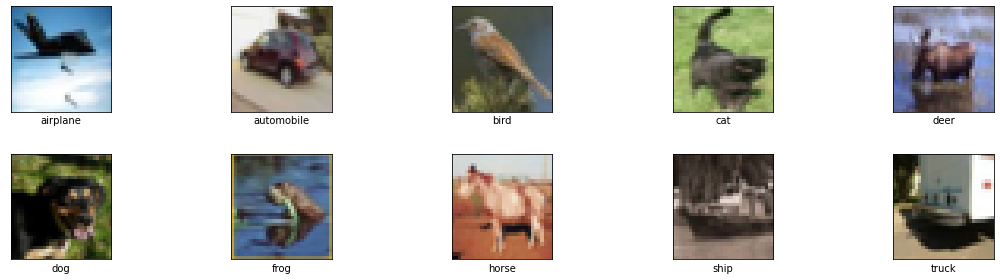

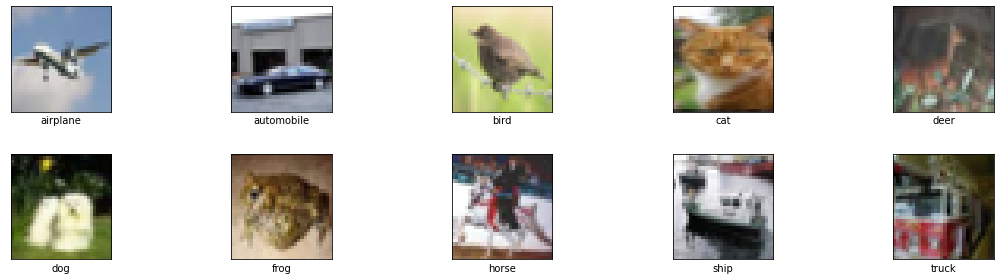

In [ ]:
print_Images(X_train, Y_train,cifar_dict,random = True)
print_Images(X_test, Y_test,cifar_dict,random = True)

In [ ]:
class CIFAR_Dataset(Dataset):
    def __init__(self, X, Y, transforms):
        self.transforms = transforms
        self.X_data = X
        self.Y_data = np.array(Y,dtype = np.long)

    def __len__(self):
        # return total dataset size
        return self.X_data.shape[0]

    def __getitem__(self, index):
        img = self.X_data[index].squeeze()
        img = Image.fromarray(img)
        label = self.Y_data[index]
        img_transformed = self.transforms(img)
        return img_transformed, label

BATCH_SIZE = 256
train_dataset = CIFAR_Dataset(X_train, Y_train,transforms = transform_train)
test_dataset = CIFAR_Dataset(X_test, Y_test,transforms = transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle= True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100,shuffle= False, num_workers=0)
N_train = train_dataset.__len__()
N_test = test_dataset.__len__()

# Load Pre-trained DenseNet Model to save time

In [ ]:
if use_data == 'Cifar-10':
  num_classes = 10
  model = '10'
elif use_data == 'Cifar-100':
  num_classes = 100
  model = '100'

save_dir = '/content/drive/MyDrive/ColabNotebooks/LB-CNN/Models/Cifar{}_DenseNet'.format(model)
num_input_channels = 3

!cp /content/drive/MyDrive/ColabNotebooks/LB-CNN/DenseNet/DenseNet.py DenseNet.py
from DenseNet import DenseNet
growth_rate = 12
layers = [16,16,16]
net = DenseNet(growth_rate = growth_rate,layers = layers,num_classes = num_classes,channels = num_input_channels)

In [ ]:
dense_net_dict = torch.load(save_dir + '/Cifar{}_DenseNet.model'.format(model))
net.load_state_dict(dense_net_dict)
print("Total parameters: {}\t".format(sum([np.prod(p.size()) for p in net.parameters()])))

Total parameters: 769162	


In [ ]:
print(net)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (denseblock1): DenseBlock(
      (layers): ModuleDict(
        (denselayer1): DenseCompositionFunction(
          (bn_1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_1): Conv2d(24, 48, kernel_size=[1, 1], stride=[1, 1], bias=False)
          (bn_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_2): Conv2d(48, 12, kernel_size=[3, 3], stride=[1, 1], padding=(1, 1), bias=False)
        )
        (denselayer2): DenseCompositionFunction(
          (bn_1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_1): Conv2d(36, 48, kernel_size=[1, 1], stride=[1, 1], bias=False)
          (bn_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_2): Conv2d(48, 12, kernel_size=[3, 3]

# Test Performance of Pre-trained Model

In [ ]:
def test(model,testloader,N_test):
    test_acc = 0.0
    for i, (images, labels) in enumerate(testloader):
        image_batch = images.to(device)
        labels_batch = labels.to(device)
        model.eval()
        # Predict classes using images from the test set
        _, out_classifier = model(image_batch)
        _, prediction = torch.max(out_classifier.data, 1)

        test_acc += torch.sum(prediction == labels_batch.data).cpu().item()
    # Compute the average acc and loss over all 10000 test images
    test_acc = test_acc / N_test
    print("Test Accuracy: {:.2f}%".format(100*test_acc))
    return test_acc

In [ ]:
_ = test(net.to(device),test_loader,N_test)

Test Accuracy: 95.01%


# Pre-specified Codebook Manifest Model

In [ ]:
for i, param in enumerate(net.parameters()):        
  if i < 231: #Freeze some layers to speed up training and save memory
    param.requires_grad = False
    print("Freezing Parameter: {}-{}".format(i,param.shape))

Freezing Parameter: 0-torch.Size([24, 3, 3, 3])
Freezing Parameter: 1-torch.Size([24])
Freezing Parameter: 2-torch.Size([24])
Freezing Parameter: 3-torch.Size([48, 24, 1, 1])
Freezing Parameter: 4-torch.Size([48])
Freezing Parameter: 5-torch.Size([48])
Freezing Parameter: 6-torch.Size([12, 48, 3, 3])
Freezing Parameter: 7-torch.Size([36])
Freezing Parameter: 8-torch.Size([36])
Freezing Parameter: 9-torch.Size([48, 36, 1, 1])
Freezing Parameter: 10-torch.Size([48])
Freezing Parameter: 11-torch.Size([48])
Freezing Parameter: 12-torch.Size([12, 48, 3, 3])
Freezing Parameter: 13-torch.Size([48])
Freezing Parameter: 14-torch.Size([48])
Freezing Parameter: 15-torch.Size([48, 48, 1, 1])
Freezing Parameter: 16-torch.Size([48])
Freezing Parameter: 17-torch.Size([48])
Freezing Parameter: 18-torch.Size([12, 48, 3, 3])
Freezing Parameter: 19-torch.Size([60])
Freezing Parameter: 20-torch.Size([60])
Freezing Parameter: 21-torch.Size([48, 60, 1, 1])
Freezing Parameter: 22-torch.Size([48])
Freezing Pa

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/LB-CNN/LB_CNN_Models/Manifest_Model.py Manifest_Model.py
from Manifest_Model import Manifest_Model

In [ ]:
def randomCodeBook(K,M):
    N = 1000
    rand_sample = np.random.randint(low = 0,high = 2,size = [N,16])
    index = np.random.choice(np.arange(N),size = K,replace = False)
    sample = rand_sample[index,:]
    for k in range(K):
        rowSum = sample[k,:].sum()
        while rowSum < M/2 - 1:
            index = np.random.choice(np.arange(N),size = 1,replace = False)[0]
            sample[k,:] = rand_sample[index,:]
            rowSum = sample[k,:].sum()
    return 2*sample-1
            

In [ ]:
if use_data == 'Cifar-10':
  num_classes = 10
  model = '10'
  code_size = 5
  sub_problem1 = np.array([-1,-1,1,1,1,1,1,1,-1,-1]) #Natural
  sub_problem2 = np.array([1,-1,1,-1,-1,-1,-1,-1,-1,-1]) #Sky/Land
  sub_problem3 = np.array([1,-1,1,1,-1,-1,1,-1,1,-1]) #Mixed
  sub_problem4 = np.array([1,-1,-1,1,1,-1,1,-1,1,-1]) #Extra
  sub_problem5 = np.array([1,1,-1,-1,1,-1,1,1,1,1]) #Extra
  code_book = np.array([sub_problem1,sub_problem2,sub_problem3,sub_problem4,sub_problem5]).T
  code_book_df = pd.DataFrame(code_book,index = cifar_dict.values(),columns = ['SubProblem1','SubProblem2','SubProblem3','SubProblem4','SubProblem5'])
elif use_data == 'Cifar-100':
  num_classes = 100
  model = '100'
  code_size = 16
  randomCodeBook(num_classes,code_size)

In [ ]:
code_book_df

,SubProblem1,SubProblem2,SubProblem3,SubProblem4,SubProblem5
airplane,-1,1,1,1,1
automobile,-1,-1,-1,-1,1
bird,1,1,1,-1,-1
cat,1,-1,1,1,-1
deer,1,-1,-1,1,1
dog,1,-1,-1,-1,-1
frog,1,-1,1,1,1
horse,1,-1,-1,-1,1
ship,-1,-1,1,1,1
truck,-1,-1,-1,-1,1


In [ ]:
class CIFAR_Dataset(Dataset):
    def __init__(self, X, Y,code_book, transforms):
        self.transforms = transforms
        self.X_data = X
        self.Y_data = np.array(Y,dtype = np.long)
        self.Z = np.stack([code_book[y,:] for y in self.Y_data],axis =0).astype(np.float32)

    def __len__(self):
        # return total dataset size
        return self.X_data.shape[0]

    def __getitem__(self, index):
        img = self.X_data[index].squeeze()
        img = Image.fromarray(img, mode = 'RGB')
        label = self.Y_data[index]
        z = self.Z[index,:]
        img_transformed = self.transforms(img)
        return img_transformed, label, z

BATCH_SIZE = 512
train_dataset = CIFAR_Dataset(X_train, Y_train,code_book, transforms = transform_train)
test_dataset = CIFAR_Dataset(X_test, Y_test,code_book, transforms = transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle= True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100,shuffle= False, num_workers=0)
N_train = train_dataset.__len__()
N_test = test_dataset.__len__()

In [ ]:
class LogLikelihood_Loss(torch.nn.Module):
    def __init__(self):
        super(LogLikelihood_Loss,self).__init__()
    def forward(self,ll):
        self.ll = ll
        self.neg_ll = -1.0*self.ll
        self.neg_ll = self.neg_ll /BATCH_SIZE
        return self.neg_ll

In [ ]:
def manifest_training(model,cnn_model,train_loader,learning_rate, num_epochs, N_train, save_dir):
  params =[{'params':cnn_model.parameters(), 'lr': learning_rate, 'weight_decay': 0},
            {'params': model.beta_tensor, 'lr': learning_rate, 'weight_decay': 1e-5},
            {'params': model.beta_0_tensor, 'lr': learning_rate, 'weight_decay': 0},
            {'params': model.alpha_tensor, 'lr': learning_rate, 'weight_decay': 1e-5},
            {'params': model.alpha_0_tensor, 'lr': learning_rate, 'weight_decay': 0}]

  optimizer = torch.optim.SGD(params, lr= learning_rate,momentum = 0.9, weight_decay= 1e-5, nesterov=True)
  loss_fn = LogLikelihood_Loss()
  MILESTONES = [55,95,130]
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1)

  train_loss_list = []
  train_acc_list = []
  train_acc_list2 = []
  model.train()
  cnn_model.train()
  for epoch in range(num_epochs):
    train_acc = 0.0
    train_acc2 = 0.0
    train_loss = 0.0
    for i, (X, labels, bern_labels) in enumerate(train_loader):
      image_batch = X.type(torch.DoubleTensor).to(device)
      labels_batch = labels.type(torch.LongTensor).to(device)
      Z_batch = bern_labels.type(torch.DoubleTensor).to(device)
      optimizer.zero_grad()

      out, out_classifier = cnn_model(image_batch)

      ll = model(out,Z_batch,labels_batch)

      loss = loss_fn(ll)
      loss.backward()
      optimizer.step()
      train_loss += loss.cpu().data.item()*BATCH_SIZE
      Y_pred_Z,Y_pred_EZ = model.predict_Y(out)

      train_acc += torch.sum(Y_pred_Z == labels_batch.data).cpu().item()
      train_acc2 += torch.sum(Y_pred_EZ == labels_batch.data).cpu().item()
    scheduler.step()
    train_loss_list.append(train_loss)
    train_acc = 100*train_acc /N_train
    train_acc2 = 100*train_acc2 /N_train
    train_acc_list.append(train_acc)
    train_acc_list2.append(train_acc2)
    print("Epoch {}, Train Accuracy: {:.2f}%, Train Accuracy E[Z|X]: {:.2f}% , TrainLoss: {:.4f}".format(epoch, train_acc, train_acc2, train_loss))
    if epoch % 20 == 0:
      model.save_models(epoch,optimizer.state_dict(),save_dir)
  model.save_models(epoch,optimizer.state_dict(),save_dir) #Save at end
  return train_loss_list, train_acc_list, train_acc_list2

In [ ]:
def manifest_test(model,cnn_model,testloader,N_test):
    test_acc = 0.0
    test_acc2 = 0.0
    cnn_model.eval()
    model.eval()
        
    for i, (X, labels, bern_labels) in enumerate(test_loader):
        image_batch = X.type(torch.DoubleTensor).to(device)
        Z_batch = bern_labels.type(torch.DoubleTensor).to(device)
        labels_batch = labels.type(torch.LongTensor).to(device)
        
        
        out, out_classifier = cnn_model(image_batch)
        
        Y_pred,Y_predEZ = model.predict_Y(out)

        test_acc += torch.sum(Y_pred == labels_batch.data).cpu().item()
        test_acc2 += torch.sum(Y_predEZ == labels_batch.data).cpu().item()
    
    test_acc = test_acc / N_test
    test_acc2 = test_acc2 / N_test
    print("Test Accuracy: {:.2f}%".format(100*test_acc))
    print("Test Accuracy using E[Z|X]: {:.2f}%".format(100*test_acc2))
    return test_acc

In [ ]:
num_features = 342
num_classes = 10
net_manifest = Manifest_Model(num_features,num_classes,code_size)

In [ ]:
save_dir = '/content/drive/MyDrive/ColabNotebooks/LB-CNN/Models'
learning_rate = 1.0
num_epochs = 150
train_loss_list, train_acc_list, train_acc_list2 = manifest_training(net_manifest.to(device),net.type(torch.DoubleTensor).to(device),train_loader,learning_rate, num_epochs, N_train, save_dir)

Epoch 0, Train Accuracy: 68.32%, Train Accuracy E[Z|X]: 69.28% , TrainLoss: 60433.8835
Check Point Saved
Epoch 1, Train Accuracy: 77.10%, Train Accuracy E[Z|X]: 77.92% , TrainLoss: 38829.6865
Epoch 2, Train Accuracy: 79.41%, Train Accuracy E[Z|X]: 79.92% , TrainLoss: 34486.7994
Epoch 3, Train Accuracy: 80.69%, Train Accuracy E[Z|X]: 81.01% , TrainLoss: 32040.5309
Epoch 4, Train Accuracy: 81.43%, Train Accuracy E[Z|X]: 81.63% , TrainLoss: 30656.0667
Epoch 5, Train Accuracy: 81.93%, Train Accuracy E[Z|X]: 82.25% , TrainLoss: 29293.5298
Epoch 6, Train Accuracy: 82.17%, Train Accuracy E[Z|X]: 82.36% , TrainLoss: 28914.5270
Epoch 7, Train Accuracy: 82.70%, Train Accuracy E[Z|X]: 82.86% , TrainLoss: 27492.5428
Epoch 8, Train Accuracy: 82.80%, Train Accuracy E[Z|X]: 83.04% , TrainLoss: 27225.1729
Epoch 9, Train Accuracy: 83.08%, Train Accuracy E[Z|X]: 83.39% , TrainLoss: 26633.4087
Epoch 10, Train Accuracy: 83.40%, Train Accuracy E[Z|X]: 83.59% , TrainLoss: 26391.6200
Epoch 11, Train Accuracy

# Treat Code as Latent and use EM Algorithm

In [ ]:
class CIFAR_Dataset(Dataset):
    def __init__(self, X, Y, transforms):
        self.transforms = transforms
        self.X_data = X
        self.Y_data = np.array(Y,dtype = np.long)

    def __len__(self):
        # return total dataset size
        return self.X_data.shape[0]

    def __getitem__(self, index):
        img = self.X_data[index].squeeze()
        img = Image.fromarray(img)
        label = self.Y_data[index]
        img_transformed = self.transforms(img)
        return img_transformed, label

BATCH_SIZE = 256
train_dataset = CIFAR_Dataset(X_train, Y_train,transforms = transform_train)
test_dataset = CIFAR_Dataset(X_test, Y_test,transforms = transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle= True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100,shuffle= False, num_workers=0)
N_train = train_dataset.__len__()
N_test = test_dataset.__len__()

In [ ]:
class LogLikelihood_Loss(torch.nn.Module):
    def __init__(self):
        super(LogLikelihood_Loss,self).__init__()
    def forward(self,ll):
        self.ll = ll
        self.neg_ll = -1.0*self.ll
        self.neg_ll = self.neg_ll /BATCH_SIZE
        return self.neg_ll

In [ ]:
def latent_training(model,cnn_model,train_loader,learning_rate, num_epochs, N_train, save_dir):
  params =[{'params':cnn_model.parameters(), 'lr': learning_rate, 'weight_decay': 1e-5},
            {'params': model.beta_tensor, 'lr': learning_rate, 'weight_decay': 1e-5},
            {'params': model.beta_0_tensor, 'lr': learning_rate, 'weight_decay': 0},
            {'params': model.alpha_tensor, 'lr': learning_rate, 'weight_decay': 1e-5},
            {'params': model.alpha_0_tensor, 'lr': learning_rate, 'weight_decay': 0}]

  optimizer = torch.optim.SGD(params, lr= learning_rate,momentum = 0.9, weight_decay= 1e-5, nesterov=True)
  loss_fn = LogLikelihood_Loss()
  MILESTONES = [80,150,250]
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1)

  train_loss_list = []
  train_acc_list = []
  train_acc_list2 = []
  model.train()
  cnn_model.train()
  for epoch in range(num_epochs):
    train_acc = 0.0
    train_acc2 = 0.0
    train_loss = 0.0
    for i, (X, labels) in enumerate(train_loader):
      image_batch = X.to(device).type(torch.FloatTensor).to(device)
      labels_batch = labels.to(device)
      optimizer.zero_grad()

      out, out_classifier = cnn_model(image_batch)

      ll = model(out,labels_batch)

      loss = loss_fn(ll)
      loss.backward()
      optimizer.step()
      train_loss += loss.cpu().data.item()*BATCH_SIZE
      Y_pred_Z,Y_pred_EZ = model.predict_Y(out)

      train_acc += torch.sum(Y_pred_Z == labels_batch.data).cpu().item()
      train_acc2 += torch.sum(Y_pred_EZ == labels_batch.data).cpu().item()
    scheduler.step()
    train_loss_list.append(train_loss)
    train_acc = 100*train_acc /N_train
    train_acc2 = 100*train_acc2 /N_train
    train_acc_list.append(train_acc)
    train_acc_list2.append(train_acc2)
    print("Epoch {}, Train Accuracy: {:.2f}%, Train Accuracy E[Z|X]: {:.2f}% , TrainLoss: {:.4f}".format(epoch, train_acc, train_acc2, train_loss))
    if epoch % 50 == 0:
      model.save_models(epoch,optimizer.state_dict(),save_dir)
  model.save_models(epoch,optimizer.state_dict(),save_dir)
  return train_loss_list, train_acc_list, train_acc_list2

In [ ]:
def latent_test(model,cnn_model,testloader,N_test):
    test_acc = 0.0
    test_acc2 = 0.0
    cnn_model.eval()
    model.eval()
        
    for i, (X, labels) in enumerate(test_loader):
        image_batch = X.type(torch.FloatTensor).to(device)
        labels_batch = labels.type(torch.LongTensor).to(device)
        out, out_classifier = cnn_model(image_batch)
        Y_pred,Y_predEZ = model.predict_Y(out)

        test_acc += torch.sum(Y_pred == labels_batch.data).cpu().item()
        test_acc2 += torch.sum(Y_predEZ == labels_batch.data).cpu().item()
    
    test_acc = test_acc / N_test
    test_acc2 = test_acc2 / N_test
    print("Test Accuracy: {:.2f}%".format(100*test_acc))
    print("Test Accuracy using E[Z|X]: {:.2f}%".format(100*test_acc2))
    return test_acc

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/LB-CNN/LB_CNN_Models/LB_CNN.py LB_CNN.py
from LB_CNN import LB_CNN

!cp /content/drive/MyDrive/ColabNotebooks/LB-CNN/DenseNet/DenseNet.py DenseNet.py
from DenseNet import DenseNet

In [ ]:
if use_data == 'Cifar-10':
  num_classes = 10
  model = '10'
elif use_data == 'Cifar-100':
  num_classes = 100
  model = '100'

save_dir = '/content/drive/MyDrive/ColabNotebooks/LB-CNN/Models/Cifar{}_DenseNet'.format(model)
num_input_channels = 3
growth_rate = 12
layers = [16,16,16]

net = DenseNet(growth_rate = growth_rate,layers = layers,num_classes = num_classes,channels = num_input_channels)

dense_net_dict = torch.load(save_dir + '/Cifar{}_DenseNet.model'.format(model))
net.load_state_dict(dense_net_dict)
print("Total parameters: {}\t".format(sum([np.prod(p.size()) for p in net.parameters()])))

In [ ]:
dimension = 342
latent_size = 7

latent_net = LB_CNN(num_features,num_classes,latent_size)

In [ ]:
save_dir = '/content/drive/MyDrive/ColabNotebooks/LB-CNN/Models'
learning_rate = 1.0
num_epochs = 300

In [ ]:
train_loss_list, train_acc_list, train_acc_list2 = latent_training(latent_net.to(device),net.to(device),train_loader,learning_rate, num_epochs, N_train, save_dir)

In [ ]:
_ = latent_test(latent_net.to(device),net.to(device),test_loader,N_test)